# Supplementary Table 2. Pri-miRNA constructs

1. pre-miRNA locus
2. 100way phyloP scores
3. genomic locus and sequence of construct
4. library included
5. note
6. build table

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-10-13.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
from Bio import SeqIO
from collections import defaultdict
from os import listdir
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import gzip
%matplotlib inline

### 1. pre-miRNA locus

In [4]:
## encode miRBase structure
strfile = 'supplementary/mirbase-v21.str'
strinfos = defaultdict(list)
mir = ''
for l in open(strfile, 'rt'):
    if l.startswith('>'):
        mir = l.split()[0][1:]
    else:
        strinfos[mir].append(l.replace('\n',''))

In [5]:
def concat_seq(infos, nucs):
    ss5, ds5, match, ds3, ss3 = infos
    seq = ''
    if ds5[0] in nucs:
        ss5 = '- '+ss5
    if ds3[0] in nucs:
        ss3 = '- '+ss3
        
    for s5, d5 in zip(ss5.split(), ds5.split()):
        seq += s5+d5
    seq += match[-1]
    for d3, s3 in zip(ds3.split()[::-1], ss3.split()[::-1]):
        seq += d3[::-1]+s3[::-1]    
    seq = seq.replace('-','').replace('|','').replace(' ','')
    return seq

In [6]:
mir = 'hsa-mir-16-1'
info = strinfos[mir]
print concat_seq(info[1:6], 'ACGUacgu')

gucagcagugccuUAGCAGCACGUAAAUAUUGGCGuuaagauucuaaaauuaucuCCAGUAUUAACUGUGCUGCUGAaguaagguugac


In [7]:
def get_new_str(mir):
    nucs = 'ACGUacgu'
    ss5, ds5, match, ds3, ss3 = strinfos[mir][1:6]
    newinfo = [ '', '', '', '', '' ]
    
    for ss, ssnew, oppo, index in [ (ss5,'',ss3,0), (ss3,'',ss5,4) ]:
        for i,s in enumerate(ss):
            if s in nucs and i<match.find('|'): ssnew += 'F'
            elif s in nucs and i>match.rfind('|'): ssnew += 'L'
            elif s in nucs and oppo[i] in nucs: ssnew += 'S'
            elif s in nucs: ssnew += 'A'
            else: ssnew += s
        newinfo[index] = ssnew
    
    for ds, dsnew, index in [ (ds5,'',1), (ds3,'',3) ]:
        for i,s in enumerate(ds):
            if s in nucs and i>match.rfind('|'): dsnew += 'L'
            elif s in nucs: dsnew += 'M'
            else: dsnew += s
        newinfo[index] = dsnew
    
    if match[-1] in nucs: newinfo[2] = match[:-1] + 'L'
    else: newinfo[2] = match   
    return concat_seq(newinfo, 'FLSAM')

In [8]:
mir = 'hsa-mir-16-1'
print get_new_str(mir)

MMMMMMSSMMMSMMMMMMMMMMMMSMMMMMMMMSMSMMMLLLLLLLLLLMMMSMSMMMMMMMMSMMAMMMMMMMMMMSMMMSSMMMMMM


In [9]:
## Find pre-miRNA annotation
def parse_line(row):
    for s in row['attr'].split(';'):
        tag, value = s.split('=')
        row[tag] = value
    return row

In [10]:
# miBRase v21 gff file
gff = 'supplementary/human_mirbase-v21.gff3'
anntbl = pd.read_table(gff, header=12, sep='\t', usecols=[0,2,3,4,6,8], 
                       names=['chr','kind','start','end','strand','attr'])
anntbl = anntbl.apply(parse_line, axis=1).drop(['attr'], axis=1)
anntbl.head(3)

,Alias,Derives_from,ID,Name,chr,end,kind,start,strand
0,MI0022705,NaN,MI0022705,hsa-mir-6859-1,chr1,17436,miRNA_primary_transcript,17369,-
1,MIMAT0027618,MI0022705,MIMAT0027618,hsa-miR-6859-5p,chr1,17431,miRNA,17409,-
2,MIMAT0027619,MI0022705,MIMAT0027619,hsa-miR-6859-3p,chr1,17391,miRNA,17369,-


In [11]:
annpri = anntbl[anntbl['kind']=='miRNA_primary_transcript'].set_index('Name')
allpris = sorted(annpri.index)
print len(allpris)

1881


In [12]:
# pri-mature matching
primat = {}
for pri, row in annpri.iterrows():
    matureDerives = anntbl[anntbl['Derives_from']==row['ID']]
    primat[pri] = matureDerives['ID'].tolist()

In [13]:
# hairpin sequence
pri = 'supplementary/hairpin_mirbase-v21.fa'
priseqs = { s.id:str(s.seq) for s in SeqIO.parse(pri, 'fasta') }
print len(priseqs)

28645


In [14]:
annmat = anntbl[anntbl['kind']=='miRNA'].set_index('ID')

In [15]:
def count_len(strt):
    return strt.count('M')+strt.count('S')

In [16]:
def get_pre_seq(pri, relativepos, arm):
    overhang3 = 2
    priseq = priseqs[pri]
    pristr = get_new_str(pri)
    if arm=='5p':
        preend = [ i for i in range(len(pristr)+1) 
            if count_len(pristr[i:])<=max(0,count_len(pristr[:relativepos-1])-overhang3) ][0]
        return priseq[relativepos-1:preend]
    else: # 3p
        prestart = [ i+1 for i in range(len(pristr))
                     if count_len(pristr[:i])>=count_len(pristr[relativepos:])+overhang3 ][0]
        return priseq[prestart-1:relativepos]

In [17]:
def get_pre_annot(pri):
    matids = primat[pri]
    chrom, strand = annpri.loc[pri, ['chr','strand']]
    if len(matids)==2:
        start = min(annmat.loc[matids, 'start'])
        end = max(annmat.loc[matids, 'end'])
    elif strand=='+':
        pristart, priend = annpri.loc[pri, ['start','end']]
        matstart, matend = annmat.loc[matids[0], ['start','end']]
        if (matstart-pristart)<(priend-matend): # 5p
            start = matstart
            end = matstart + len(get_pre_seq(pri, matstart-pristart+1, '5p')) - 1
        else: # 3p
            end = matend
            start = matend - len(get_pre_seq(pri, matend-pristart+1, '3p')) + 1
    else: # strand=='-'
        pristart, priend = annpri.loc[pri, ['start','end']]
        matstart, matend = annmat.loc[matids[0], ['start','end']]
        if (matstart-pristart)<(priend-matend): # 3p
            start = matstart
            end = matstart + len(get_pre_seq(pri, priend-matstart+1, '3p')) - 1
        else: # 5p
            end = matend
            start = matend - len(get_pre_seq(pri, priend-matend+1, '5p')) + 1
    return chrom, start, end, strand

In [18]:
pri = 'hsa-mir-147b'
print get_pre_annot(pri)

('chr15', 45433060, 45433119, '+')


### 2. 100way phyloP scores
- phyloP files were downloaded from UCSC genome browser at 2019-05-03.
- They were generated by comparative alignment of human and 99 vertebrate genomes (hg38).
- They gives pair-wise conservation scores but have gaps. I split the scores by gaps so that each split file become continuous. Titles indicates start positions.
- Link: http://hgdownload.soe.ucsc.edu/goldenPath/hg38/phyloP100way/
- Snakefile: /casa/bsc/databases/human/Snakefile_1905

In [21]:
s1 = pd.read_csv('supplementary/201012_s1_pri-info.csv', header=1, index_col=0)
drosensitive = [ pri for pri in s1.index 
                 if s1.loc[pri, 'Note'].find('DROSHA KO-sensitive')>=0 ]
print len(drosensitive)

157


In [22]:
## split phyloP files
savepath = 'supplementary/phyloP100way'
#chroms = list(range(1,23)) + ['X','Y']
#CHROMS = [ 'chr%s'%c for c in chroms ]
# for chrom in CHROMS:
#     subpath = '%s/%s'%(savepath, chrom)
#     if not os.path.exists(subpath):
#         os.makedirs(subpath)
    
#     out = open('%s/init'%subpath, 'wt')
#     for l in gzip.open('%s/%s.phyloP100way.wigFix.gz'%(savepath,chrom), 'rb'):
#         if l.startswith('fixedStep'):
#             start = l.split()[2].split('=')[1]
#             out.close()
#             out = open('%s/%s.phylop.gz'%(subpath,start), 'wb')
#         else:
#             out.write(l)

In [23]:
def get_phylop_scores(chrom, start, end):
    phystarts = [ int(f.split('.')[0]) for f in listdir('%s/%s'%(savepath,chrom)) 
                  if f.endswith('.gz') ]
    init = sorted([ s for s in phystarts if s<=start ])[-1]
    nextst = sorted([ s for s in phystarts if s>start])[0]
    rels, rele = start-init, end-init
    phys = open('%s/%s/%s.phylop.gz'%(savepath,chrom,init),'rt').read().strip().split('\n')
    if len(phys) <= rels:
        if nextst > end:
            return ['-']*(end-start+1)
        else:
            return ['-']*(nextst-start) + get_phylop_scores(chrom, nextst, end)
    elif len(phys) > rele:
        return map(float, phys[rels:rele+1])
    else: # rels < len(phys) <= rele
        return map(float, phys[rels:]) + get_phylop_scores(chrom, init+len(phys), end)

In [24]:
pri = 'hsa-let-7a-1'
chrom, start, end, strand = get_pre_annot(pri)
print get_phylop_scores(chrom, start, end)

[7.481, 9.353, 8.717, 9.353, 9.353, 7.481, 8.717, 9.353, 7.481, 6.794, 9.353, 5.29, 7.481, 7.481, 9.353, 5.696, 6.884, 7.481, 8.717, 9.353, 7.481, 7.481, 5.718, 5.755, 4.879, 7.473, 9.353, 7.439, 7.481, 5.659, 6.818, 2.185, 4.454, 5.659, 7.378, 5.608, 1.717, 3.555, 0.986, 2.408, 5.659, 7.481, 7.442, 4.966, 5.947, 8.717, 9.353, 8.717, 7.481, 4.777, 8.717, 7.378, 7.481, 8.717, 7.481, 3.714, 5.613, 8.717, 3.353, 3.34, 3.694, 7.481, 8.717, 7.378, 7.481, 9.353, 7.481, 7.378, 7.481, 7.481, 7.481, 7.378]


In [25]:
phypris = {}
for pri in drosensitive+['hsa-mir-142']:
    chrom, pstart, pend, strand = get_pre_annot(pri)
    phypri = get_phylop_scores(chrom, pstart-100, pend+100)
    if strand=='-':
        phypri = phypri[::-1]
    phypris[pri] = phypri

In [26]:
phy5fs = zip(*[ phypris[pri][50:100] for pri in drosensitive ])
phy5fs = [ [ p for p in ps if p!='-' ] for ps in phy5fs ]
phy5avs = map(np.average, phy5fs)

phy3fs = zip(*[ phypris[pri][-100:-50] for pri in drosensitive ])
phy3fs = [ [ p for p in ps if p!='-' ] for ps in phy3fs ]
phy3avs = map(np.average, phy3fs)

Text(0.51,-0.23,u'5$^\\prime$ or 3$^\\prime$ flanking region')

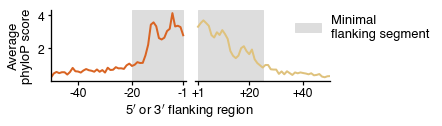

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,1.3), sharey=True)
fig.subplots_adjust(wspace=.07)

ax1.plot(phy5avs, color='#d96423', linewidth=2, zorder=2)
ax2.plot(phy3avs, color='#dfc27d', linewidth=2, zorder=2)
ax1.set_ylabel('Average\nphyloP score', fontsize=13)

ax1.tick_params(labelsize=12, width=1.2)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left='off', labelsize=12, width=1.2)

ax1.set_xticks([10, 30, 49])
ax1.set_xticklabels(['-40', '-20', '-1'])
ax1.set_xlim(0, 50)

ax2.set_xticks([0, 19, 39])
ax2.set_xticklabels(['+1', '+20', '+40'])
ax2.set_xlim(-1, 49)

ax1.axvspan(30, 49, color='#dddddd')
ax2.axvspan(0, 24, color='#dddddd', label='Minimal\nflanking segment')
ax2.legend(frameon=False, loc=(.7,.5), prop={'size':13})
fig.text(0.51, -.23, r"5$^\prime$ or 3$^\prime$ flanking region", ha='center', fontsize=13)

In [28]:
for pri in sorted(drosensitive, key=lambda x:get_pre_annot(x)[2]-get_pre_annot(x)[1]+1)[-5:]:
    print pri, get_pre_annot(pri)[2]-get_pre_annot(pri)[1]+1

hsa-let-7g 78
hsa-let-7i 78
hsa-mir-744 79
hsa-mir-98 80
hsa-mir-548o 102


### 3. genomic locus and sequence of construct

In [29]:
def rev_com_dna(seq):
    seq = seq.upper()
    seq = seq.replace('T', 'X')
    seq = seq.replace('A', 'T')
    seq = seq.replace('X', 'A')
    seq = seq.replace('G', 'Y')
    seq = seq.replace('C', 'G')
    seq = seq.replace('Y', 'C')
    return seq[::-1]

In [30]:
genome = {}
genomef = 'supplementary/hg38.fa.gz'
for g in SeqIO.parse(gzip.open(genomef, 'rb'), 'fasta'):
    genome[g.id] = str(g.seq)

In [31]:
adjust = {}
for l in open('supplementary/200414_construct_adjust.txt', 'rt'):
    pri, adj = l.split()
    adjust[pri] = int(adj)

In [32]:
extend5, extend3 = 60, 65
constinfos = {}
for pri in allpris:
    chrom, pstart, pend, strand = get_pre_annot(pri)
    if strand=='+':
        pmid = (pstart+pend)//2 + adjust[pri]
        cstart, cend = pmid-extend5+1, pmid+extend3
        constructseq = genome[chrom][cstart-1:cend].upper()
    else:
        pmid = (pstart+pend+1)//2 + adjust[pri]
        cstart, cend = pmid-extend3+1, pmid+extend5
        constructseq = rev_com_dna(genome[chrom][cstart-1:cend].upper())
    constinfos[pri] = (chrom, cstart, cend, strand, constructseq)

In [33]:
print constinfos['hsa-let-7a-2']

('chr11', 122146492, 122146616, '-', 'AGCCATTGTGACTGCATGCTCCCAGGTTGAGGTAGTAGGTTGTATAGTTTAGAATTACATCAAGGGAGATAACTGTACAGCCTCCTAGCTTTCCTTGGGTCTTGCACTAAACAACATGGTGAGAA')


### 4. library included

In [34]:
synexcel = pd.ExcelFile('supplementary/synthesis_log.xlsx')
syn1mirs = synexcel.parse('1st')[0].tolist()
syn2mirs = synexcel.parse('2nd')[0].tolist()
syn3mirs = synexcel.parse('3rd')[0].tolist()
unsynmirs = synexcel.parse('not')[0].tolist()
print len(syn1mirs), len(syn2mirs), len(syn3mirs), len(unsynmirs)

1645 78 48 80


In [35]:
library = {}
for pri in allpris:
    if pri in syn1mirs:
        library[pri] = 'set 1,2'
    elif pri in syn2mirs:
        library[pri] = 'set 2,3,4'
    elif pri in syn3mirs:
        library[pri] = 'set 3,4'
    else:
        library[pri] = 'set 5'

### 5. Sequence redundancy

In [36]:
represeqs = {}
redund = {}
for pri in allpris:
    cseq = constinfos[pri][4]
    redundancy = [ p for p in represeqs.keys() if represeqs[p]==cseq ]
    if redundancy:
        redund[pri] = redundancy[0]
        continue
    represeqs[pri] = cseq
print len(represeqs), len(redund)

1851 30


In [37]:
## reference sequence file
# adapter5 = 'GGGCCTATTCAGTTACAGCG'
# adapter3 = 'CGTACTGAAGCTAGCAAC'
# out = open('references/200416_construct_1851.fa', 'wt')
# for pri in sorted(represeqs.keys()):
#     out.write('>%s\n%s\n' % (pri,adapter5+represeqs[pri]+adapter3))
# out.close()

### 6. build table

In [38]:
cols = [ 'Pri-miRNA', 'Chr', 'Start', 'End', 'Strand', 'Construct sequence', 
         '100way phyloP scores (pre-miRNA -/+ 100nt)', 'Library included', 'Note' ]
tbl = pd.DataFrame(columns=cols)
tbl['Pri-miRNA'] = allpris
tbl = tbl.set_index('Pri-miRNA').fillna('')
tbl.head(1)

,Chr,Start,End,Strand,Construct sequence,100way phyloP scores (pre-miRNA -/+ 100nt),Library included,Note
Pri-miRNA,,,,,,,,
hsa-let-7a-1,,,,,,,,


In [39]:
for pri in allpris:
    chrom, cstart, cend, strand, constructseq = constinfos[pri]
    tbl.loc[pri, 'Chr'] = chrom
    tbl.loc[pri, 'Start'] = cstart
    tbl.loc[pri, 'End'] = cend
    tbl.loc[pri, 'Strand'] = strand
    tbl.loc[pri, 'Construct sequence'] = constructseq
    note = []
    if pri in phypris:
        tbl.loc[pri, '100way phyloP scores (pre-miRNA -/+ 100nt)'] = phypris[pri]
        note.append('DROSHA KO-sensitive')
    tbl.loc[pri, 'Library included'] = library[pri]
    if pri in redund:
        note.append('Same construct sequence with %s'%redund[pri])
    tbl.loc[pri, 'Note'] = ', '.join(note)

In [40]:
tbl.to_csv('resources/201012_s2_pri-construct.csv')

In [41]:
out = open('supplementary/201012_s2_pri-construct.csv', 'wt')
description = 'Supplementary Table 2. Pri-miRNA construct\n\n\n\n\n'
out.write(description)
for l in open('resources/201012_s2_pri-construct.csv', 'rt'):
    out.write(l)
out.close()